<a href="https://colab.research.google.com/github/YasiruSilva/Practical-Ethical-Hacking-Resources/blob/master/s2t_feature_selection_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature selection for Speech to text model

## Download dataset

In [ ]:
!sudo apt-get update
!sudo apt-get install aria2

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,046 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease [24.3 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,158 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRele

In [ ]:
datasets = [
    'https://www.openslr.org/resources/60/dev-clean.tar.gz'
]
with open('urls.txt', 'w') as f:
  f.write('\n'.join(datasets))

In [ ]:
!aria2c -i urls.txt


05/14 09:58:14 [NOTICE] Downloading 1 item(s)

05/14 09:58:14 [NOTICE] CUID#7 - Redirecting to http://us.openslr.org/resources/60/dev-clean.tar.gz
 *** Download Progress Summary as of Sun May 14 09:59:15 2023 *** 
=
[#e444ad 1.1GiB/1.2GiB(97%) CN:1 DL:20MiB ETA:1s]
FILE: /content/dev-clean.tar.gz
-


05/14 09:59:16 [NOTICE] Download complete: /content/dev-clean.tar.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
e444ad|OK  |    19MiB/s|/content/dev-clean.tar.gz

Status Legend:
(OK):download completed.


In [ ]:
!for file in *.tar.gz; do tar -xf "$file"; done

## Import packages

In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from pathlib import Path
import librosa
import shutil
import jiwer
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
tf.keras.utils.set_random_seed(1234)

## Preprocess dataset

In [ ]:
DATASET = 'LibriTTS'
# vocabulary 
VOCAB = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
batch_size = 32
def get_EN_df():
    if Path('EN_df.pkl').exists():                                        
        df = pd.read_pickle('EN_df.pkl')
        return df
    data = []
    dataset_path = Path(DATASET)
    save_path = Path('clips')
    save_path.mkdir(exist_ok=True)
    ts = 0
    for wav_path in tqdm(list(dataset_path.glob('**/*.wav'))):
        # read label for the audio file
        normalized = wav_path.with_suffix('.normalized.txt').read_text()
        # skip too long audio files to reduce training time
        if len(normalized) > 192: continue
        rs_wav = save_path/ wav_path.name
        # convert audio clip to 16kHz sample rate and single channel
        y, sr = librosa.load(wav_path, sr=16000, mono=True)
        ts += y.shape[0]
        # encode audio file to wav format and save it
        y = tf.expand_dims(y,axis=1)
        wav = tf.audio.encode_wav(y, 16000)
        tf.io.write_file(str(rs_wav), wav)
        data.append((str(rs_wav), normalized))
        
    # sort dataset by label length and shuffle by groups of batch size to reduce training time
    if len(data) % batch_size:
        data = data[:-(len(data) % batch_size)]
    data.sort(key=lambda x: len(x[1]))
    ndata = [data[i:i+batch_size] for i in range(0, len(data), batch_size)]
    np.random.shuffle(ndata)
    data = []
    for l in ndata: data += l
    df = pd.DataFrame(data, columns=['filepath', 'normalized'])
    df.to_pickle('EN_df.pkl')
    # print total length of dataset in seconds
    print(f'total seconds: {ts/16000}')
    return df
df = get_EN_df()
df

100%|██████████| 5736/5736 [00:46<00:00, 124.08it/s]

total seconds: 23866.5826875


,filepath,normalized
0,clips/1462_170142_000046_000007.wav,"Then came all those years without you, lonely ..."
1,clips/1462_170138_000001_000004.wav,"He spoke with an extreme Oxford accent, and wh..."
2,clips/6241_61943_000036_000002.wav,"The other street, situated more to the west, r..."
3,clips/1919_142785_000005_000002.wav,"Originally, the most valuable of these were fo..."
4,clips/1919_142785_000116_000002.wav,Let this again dry up by stirring over the fir...
...,...,...
5147,clips/174_84280_000004_000000.wav,Life is so much fuller than any book can be.
5148,clips/174_50561_000043_000000.wav,The third part of the game is seldom played.
5149,clips/174_168635_000026_000003.wav,We all have in our past a delightful garret.
5150,clips/174_168635_000023_000000.wav,The early days passed in this dazzled state.


## Split dataset

In [ ]:
split = int(0.80*len(df))
split -= split % batch_size
df_train = df[:split]
df_val = df[split:]
print(f'train samples: {len(df_train)}')
print(f'val samples: {len(df_val)}')
df_train

train samples: 4096
val samples: 1056


,filepath,normalized
0,clips/1462_170142_000046_000007.wav,"Then came all those years without you, lonely ..."
1,clips/1462_170138_000001_000004.wav,"He spoke with an extreme Oxford accent, and wh..."
2,clips/6241_61943_000036_000002.wav,"The other street, situated more to the west, r..."
3,clips/1919_142785_000005_000002.wav,"Originally, the most valuable of these were fo..."
4,clips/1919_142785_000116_000002.wav,Let this again dry up by stirring over the fir...
...,...,...
4091,clips/6295_244435_000034_000000.wav,"""If you've got pistols, just you think once be..."
4092,clips/1993_147965_000007_000003.wav,"As we turned back to the sitting room, grandfa..."
4093,clips/1993_147966_000007_000003.wav,At home he play violin all the time; for weddi...
4094,clips/2428_83705_000009_000000.wav,"There was William Henry, john Frank, Ferdinand..."


## Define util functions

In [ ]:
VOCAB_LEN = len(VOCAB)
# label encoder
char_to_num = tf.keras.layers.StringLookup(vocabulary=VOCAB, oov_token="", name="char_to_num")
# label decoder
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True,  name="num_to_char"
)
# print vocabulary and its length
print(char_to_num.get_vocabulary())
print(VOCAB_LEN)

['', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]
28


## Feature extraction

In [ ]:
@tf.function
def cmvn_norm(features):
    '''
    perform CMVN normalization to an array of features
    
    https://en.wikipedia.org/wiki/Cepstral_mean_and_variance_normalization
    '''
    means = tf.math.reduce_mean(features, axis=1, keepdims=True)
    var = tf.math.reduce_variance(features, axis=1, keepdims=True)
    stds = tf.math.sqrt(var) + 1e-10
    features = tf.math.subtract(features, means)
    features = tf.math.truediv(features, stds)
    return features

In [ ]:
spec_frame_length = 128
spec_frame_step = 64
spec_fft_length = 128

n_mfccs = 40
mfcc_frame_length = 512
mfcc_frame_step = 256
mfcc_fft_length = 512

### Raw

In [ ]:
def feature_raw(audio, w = 40, o = 20):
    sh = (audio.size - w + 1, w)
    st = audio.strides * 2
    return np.lib.stride_tricks.as_strided(audio, strides = st, shape = sh)[0::o]

### MFCC

In [ ]:
@tf.function
def feature_mfcc(audio, n_mfccs):
    '''
    extract mfcc, delta and delta-delta features from an audio clip
    
    https://speechprocessingbook.aalto.fi/Representations/Melcepstrum.html
    '''
    # calculate 512-point STFT with frames of 32 ms and 50% overlap.
    stfts = tf.signal.stft(audio, frame_length=mfcc_frame_length, frame_step=mfcc_frame_step,
                        fft_length=mfcc_fft_length, pad_end=True)
    spectrograms = tf.abs(stfts)
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = tf.shape(stfts)[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 8000.0, 40
    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
        upper_edge_hertz)
    mel_spectrograms = tf.matmul(spectrograms, mel_weight_matrix)

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)
    
    # apply cmvn
    mfccs = cmvn_norm(mfccs)

    mfccs = tf.expand_dims(mfccs, axis=-1)
    return mfccs

### MFCC, delta & delta-delta

In [ ]:
@tf.function
def feature_mfcc_delta(audio, n_mfccs):
    '''
    extract mfcc, delta and delta-delta features from an audio clip
    
    https://speechprocessingbook.aalto.fi/Representations/Melcepstrum.html
    https://speechprocessingbook.aalto.fi/Representations/Deltas_and_Delta-deltas.html
    '''
    # calculate 512-point STFT with frames of 32 ms and 50% overlap.
    stfts = tf.signal.stft(audio, frame_length=mfcc_frame_length, frame_step=mfcc_frame_step,
                        fft_length=mfcc_fft_length, pad_end=True)
    spectrograms = tf.abs(stfts)
    # Warp the linear scale spectrograms into the mel-scale.
    num_spectrogram_bins = tf.shape(stfts)[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 20.0, 8000.0, 40
    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, 16000, lower_edge_hertz,
        upper_edge_hertz)
    mel_spectrograms = tf.matmul(spectrograms, mel_weight_matrix)

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)
    padding = tf.constant([[1, 0], [0, 0]])
    delta = mfccs - tf.pad(mfccs[:-1], padding, mode="CONSTANT", constant_values=0)
    delta_delta = delta - tf.pad(delta[:-1], padding, mode="CONSTANT", constant_values=0)

    # apply cmvn
    mfccs = cmvn_norm(mfccs)
    delta = cmvn_norm(delta)
    delta_delta = cmvn_norm(delta_delta)

    features = tf.stack([mfccs, delta, delta_delta], axis=-1)
    return features

## Create datasets

In [ ]:
def get_single_sample_raw(wav_path, label):
    audio, sr = librosa.load(wav_path, sr=1600)
    features = tf.convert_to_tensor(feature_raw(audio, 40, 20), dtype=tf.float32)
    features = tf.expand_dims(features, axis=-1)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return features, label

def generator_raw(df):
    for wav_path, label in df:
        yield get_single_sample_raw(wav_path.decode(), label.decode())

@tf.function
def get_single_sample_mfcc(wav_path, label):
    '''
    get sigle features, label pair for an audio file
    '''
    file = tf.io.read_file(wav_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    features = feature_mfcc(audio, n_mfccs=n_mfccs)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return features, label

@tf.function
def get_single_sample_mfcc_delta(wav_path, label):
    '''
    get sigle features, label pair for an audio file
    '''
    file = tf.io.read_file(wav_path)
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    features = feature_mfcc_delta(audio, n_mfccs=n_mfccs)
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return features, label

In [ ]:
def create_dataset(df, feature, cache_dir):
    # remove cache directory if exists
    cache_dir = Path(cache_dir)
    if cache_dir.exists():
        shutil.rmtree(cache_dir)
    cache_dir.mkdir(parents=True)
    # create dataset
    if feature == 'raw':
        dataset = tf.data.Dataset.from_generator(
            generator_raw,
            args=(df,),
            output_signature=(
                tf.TensorSpec(shape=(None, 40, 1), dtype=tf.float32),
                tf.TensorSpec(shape=(None,), dtype=tf.int64)
                )
            )
    else:
        dataset = tf.data.Dataset.from_tensor_slices(
            (list(df["filepath"]), list(df["normalized"]))
        )
        if feature == 'mfcc':
            dataset = dataset.map(get_single_sample_mfcc, num_parallel_calls=tf.data.AUTOTUNE)
        elif feature == 'mfcc_delta':
            dataset = dataset.map(get_single_sample_mfcc_delta, num_parallel_calls=tf.data.AUTOTUNE)
        else: raise ValueError(f'Invalid feature: {feature}')
    dataset = (
        dataset.padded_batch(batch_size)
               .cache(str(cache_dir))
               .prefetch(buffer_size=tf.data.AUTOTUNE)
        )
    return dataset

In [ ]:
!rm -r ds_cache

ds_train_raw = create_dataset(df_train, 'raw', '/content/ds_cache/raw/train/')
ds_val_raw = create_dataset(df_val, 'raw', '/content/ds_cache/raw/val/')

ds_train_mfcc = create_dataset(df_train, 'mfcc', '/content/ds_cache/mfcc/train/')
ds_val_mfcc = create_dataset(df_val, 'mfcc', '/content/ds_cache/mfcc/val/')

ds_train_mfcc_delta = create_dataset(df_train, 'mfcc_delta', '/content/ds_cache/mfcc_delta/train/')
ds_val_mfcc_delta = create_dataset(df_val, 'mfcc_delta', '/content/ds_cache/mfcc_delta/val/')

In [ ]:
for b in ds_val_raw.take(1):
    print(b[0].shape)

for b in ds_val_mfcc.take(1):
    print(b[0].shape)

for b in ds_val_mfcc_delta.take(1):
    print(b[0].shape)

(32, 485, 40, 1)
(32, 380, 40, 1)
(32, 380, 40, 3)


## Model creation

In [ ]:
@tf.function
def CTCLoss(labels, logits):
    '''
    CTC loss function
    
    https://distill.pub/2017/ctc/
    '''
    batch_size = tf.shape(labels)[0]
    label_length = tf.shape(labels)[1]
    logit_length = tf.shape(logits)[1]
    label_length = tf.fill((batch_size, ), label_length)
    logit_length = tf.fill((batch_size, ), logit_length)
    loss = tf.nn.ctc_loss(labels, logits, label_length, logit_length, logits_time_major=False, blank_index=-1)
    return loss

In [ ]:
def conv_block(n, filters, kernel, dropout, input_):
    '''
    SeparableConv2D layer block
    '''
    output = layers.SeparableConv2D(
        filters=filters,
        kernel_size=kernel,
        data_format='channels_last',
        name=f'sconv2d_{n}'
	  )(input_)
    output = layers.ReLU(
        name=f'relu_{n}'
    )(output)
    output = layers.Dropout(
        rate=dropout
    )(output)
    output = layers.BatchNormalization(
        axis=-1, 
        name=f'normalization_{n}'
    )(output)
    return output

def rnn_block(n, units, dropout, input_):
    '''
    Bidirectional GRU layer block
    '''
    layer = layers.GRU(
        units=units,
        return_sequences=True,
        name=f'gru_{n}'
    )
    output = layers.Bidirectional(
        layer=layer,
        merge_mode='concat',
        name=f'bidirectional_{n}'
    )(input_)
    output = layers.Dropout(
        rate=dropout
    )(output)
    return output

def build_model(input_shape):
    '''
    build and compile the model
    '''
    input_ = layers.Input(
        shape=input_shape,
        name='input'
    )
    output = conv_block(1, 64, (7,1), 0.20, input_)
    output = conv_block(2, 64, (7,1), 0.20, output)
    
    # reshape the output received from convolutional layers to a compatible shape to feed into the RNN layers
    output = layers.Reshape(
        target_shape=(-1, output.shape[-2] * output.shape[-1])
    )(output)

    output = rnn_block(1, 512, 0.20, output)
    output = rnn_block(2, 1024, 0.20, output)
    output = rnn_block(3, 512, 0.00, output)
    
    # output length will be VOCAB_LEN+1. extra label is used as CTC blank token
    output = layers.Dense(
        units=VOCAB_LEN + 1, 
        activation=None, # CTCLoss performs softmax
        name='dense'
    )(output)

    model = tf.keras.Model(input_, output, name='Speech2Text-EN')
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [ ]:
raw_model = build_model((None, 40, 1))
raw_model.summary()

Model: "Speech2Text-EN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 40, 1)]     0         
                                                                 
 sconv2d_1 (SeparableConv2D)  (None, None, 40, 64)     135       
                                                                 
 relu_1 (ReLU)               (None, None, 40, 64)      0         
                                                                 
 dropout_5 (Dropout)         (None, None, 40, 64)      0         
                                                                 
 normalization_1 (BatchNorma  (None, None, 40, 64)     256       
 lization)                                                       
                                                                 
 sconv2d_2 (SeparableConv2D)  (None, None, 40, 64)     4608      
                                                    

In [ ]:
mfcc_model = build_model((None, n_mfccs, 1))
mfcc_model.summary()

Model: "Speech2Text-EN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 40, 1)]     0         
                                                                 
 sconv2d_1 (SeparableConv2D)  (None, None, 40, 64)     135       
                                                                 
 relu_1 (ReLU)               (None, None, 40, 64)      0         
                                                                 
 dropout_5 (Dropout)         (None, None, 40, 64)      0         
                                                                 
 normalization_1 (BatchNorma  (None, None, 40, 64)     256       
 lization)                                                       
                                                                 
 sconv2d_2 (SeparableConv2D)  (None, None, 40, 64)     4608      
                                                    

In [ ]:
mfcc_delta_model = build_model((None, n_mfccs, 3))
mfcc_delta_model.summary()

Model: "Speech2Text-EN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 40, 3)]     0         
                                                                 
 sconv2d_1 (SeparableConv2D)  (None, None, 40, 64)     277       
                                                                 
 relu_1 (ReLU)               (None, None, 40, 64)      0         
                                                                 
 dropout_10 (Dropout)        (None, None, 40, 64)      0         
                                                                 
 normalization_1 (BatchNorma  (None, None, 40, 64)     256       
 lization)                                                       
                                                                 
 sconv2d_2 (SeparableConv2D)  (None, None, 40, 64)     4608      
                                                    

## Training

In [ ]:
history_raw = raw_model.fit(
    ds_train_raw,
    validation_data=ds_val_raw,
    epochs=5
)

Epoch 1/5
128/128 [==============================] - 331s 2s/step - loss: 299.6541 - val_loss: 297.4692
Epoch 2/5
128/128 [==============================] - 261s 2s/step - loss: 228.8667 - val_loss: 352.8766
Epoch 3/5
128/128 [==============================] - 260s 2s/step - loss: 218.8992 - val_loss: 261.1986
Epoch 4/5
128/128 [==============================] - 259s 2s/step - loss: 215.1749 - val_loss: 213.9495
Epoch 5/5
128/128 [==============================] - 259s 2s/step - loss: 209.4832 - val_loss: 203.9190


In [ ]:
history_mfcc = mfcc_model.fit(
    ds_train_mfcc,
    validation_data=ds_val_mfcc,
    epochs=5
)

Epoch 1/5
128/128 [==============================] - 246s 2s/step - loss: 331.6111 - val_loss: 267.9204
Epoch 2/5
128/128 [==============================] - 206s 2s/step - loss: 233.4692 - val_loss: 220.4803
Epoch 3/5
128/128 [==============================] - 206s 2s/step - loss: 227.9438 - val_loss: 220.2748
Epoch 4/5
128/128 [==============================] - 206s 2s/step - loss: 227.8145 - val_loss: 219.8981
Epoch 5/5
128/128 [==============================] - 207s 2s/step - loss: 227.6096 - val_loss: 219.7213


In [ ]:
history_mfcc_delta = mfcc_delta_model.fit(
    ds_train_mfcc_delta,
    validation_data=ds_val_mfcc_delta,
    epochs=5
)

Epoch 1/5
128/128 [==============================] - 289s 2s/step - loss: 315.5906 - val_loss: 429.9374
Epoch 2/5
128/128 [==============================] - 207s 2s/step - loss: 235.3689 - val_loss: 315.8081
Epoch 3/5
128/128 [==============================] - 207s 2s/step - loss: 227.5312 - val_loss: 221.4134
Epoch 4/5
128/128 [==============================] - 207s 2s/step - loss: 227.6643 - val_loss: 220.6815
Epoch 5/5
128/128 [==============================] - 208s 2s/step - loss: 226.9048 - val_loss: 221.6305


## Comparison

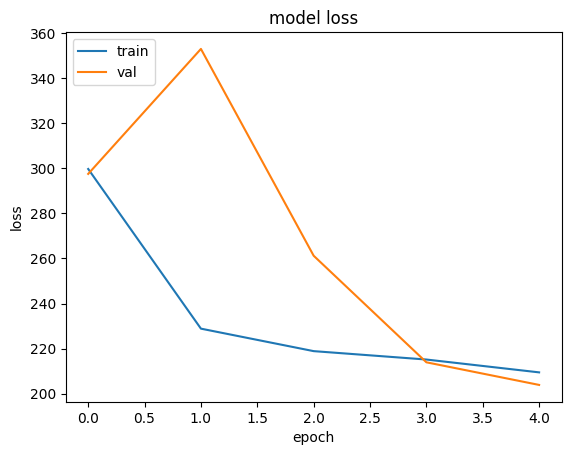

In [ ]:
plt.plot(history_raw.history['loss'])               #Best predictions denne mona feature ek use klot da kiyl blnna
plt.plot(history_raw.history['val_loss'])
plt.title('model loss')                          
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

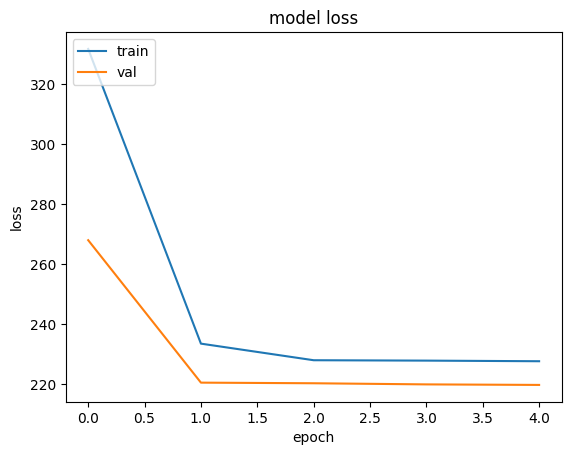

In [ ]:
plt.plot(history_mfcc.history['loss'])
plt.plot(history_mfcc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

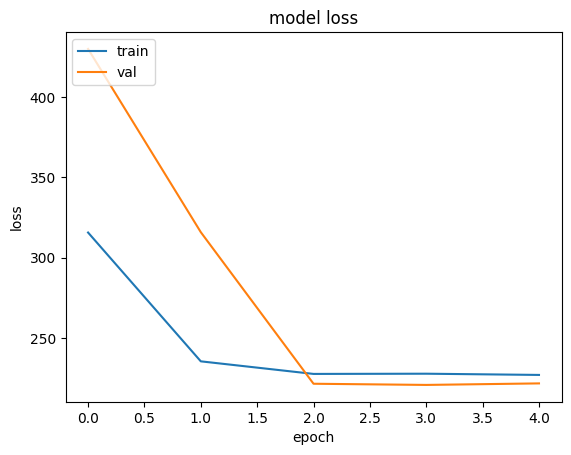

In [ ]:
plt.plot(history_mfcc_delta.history['loss'])
plt.plot(history_mfcc_delta.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def decode_batch_predictions(logits):
    '''
    decode a batch of predictions. uses CTC greedy decoder
    '''
    logits = tf.nn.softmax(logits)
    logits = tf.transpose(logits, perm=[1,0,2])
    logits_len = tf.fill((logits.shape[1],), logits.shape[0])
    results = tf.nn.ctc_greedy_decoder(logits, sequence_length=logits_len, blank_index=-1)[0][0]
    results = tf.sparse.to_dense(results)
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [ ]:
predictions = []
targets = []
for batch in ds_val_raw:
    X, y = batch
    batch_predictions = raw_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = jiwer.wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}") #word error calculation/percentage
print("-" * 100)

1/1 [==============================] - 0s 248ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9916
----------------------------------------------------------------------------------------------------


In [ ]:
predictions = []
targets = []
for batch in ds_val_mfcc:
    X, y = batch
    batch_predictions = mfcc_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = jiwer.wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

1/1 [==============================] - 0s 188ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0000
----------------------------------------------------------------------------------------------------


In [ ]:
predictions = [] 
targets = []
for batch in ds_val_mfcc_delta:
    X, y = batch
    batch_predictions = mfcc_delta_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = jiwer.wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

1/1 [==============================] - 0s 180ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9905
----------------------------------------------------------------------------------------------------


## Summary

Best feature:

    MFCC, delta & delta-delta with 0.9905 WER after 5 epochs